<a href="https://colab.research.google.com/github/rakeshredd4512/Bone-Fracture-Detection/blob/master/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [8]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [9]:

# Load training data
train = data("/content/drive/My Drive/Bone_Fracture_Binary_Classification/train")
print(train.head())


                                               image          label
0  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured
1  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured
2  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured
3  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured
4  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured


In [10]:
# Load training data
test = data("/content/drive/My Drive/Bone_Fracture_Binary_Classification/test")
print(test.head())


                                               image          label
0  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured
1  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured
2  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured
3  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured
4  /content/drive/My Drive/Bone_Fracture_Binary_C...  not fractured


In [13]:
# Load training data
val = data("/content/drive/My Drive/Bone_Fracture_Binary_Classification/val")
print(val.head())

                                               image      label
0  /content/drive/My Drive/Bone_Fracture_Binary_C...  fractured
1  /content/drive/My Drive/Bone_Fracture_Binary_C...  fractured
2  /content/drive/My Drive/Bone_Fracture_Binary_C...  fractured
3  /content/drive/My Drive/Bone_Fracture_Binary_C...  fractured
4  /content/drive/My Drive/Bone_Fracture_Binary_C...  fractured


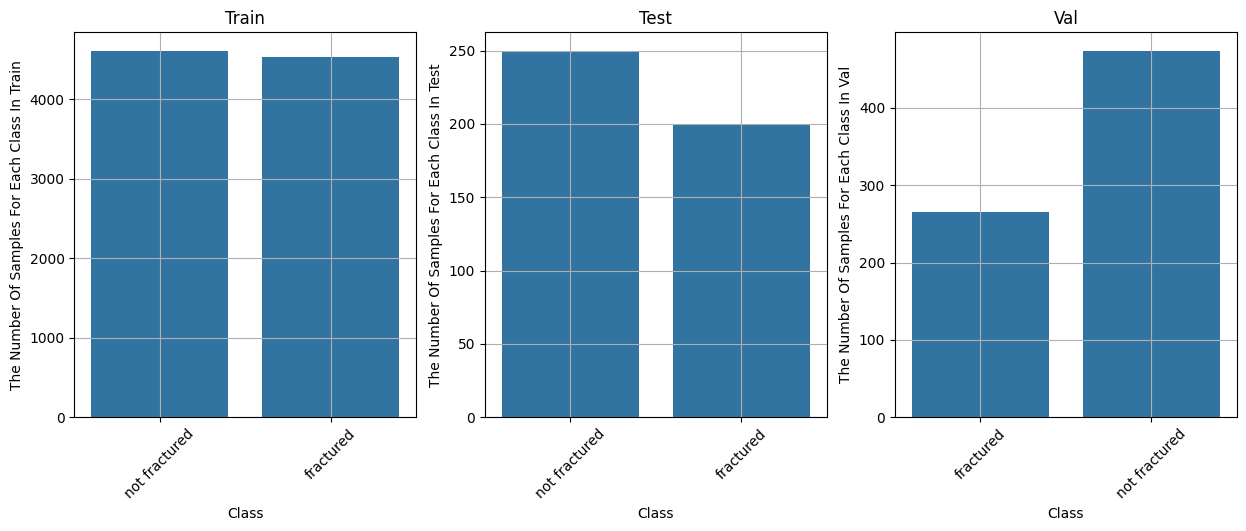

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,3)
ax = sns.countplot(x=val.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

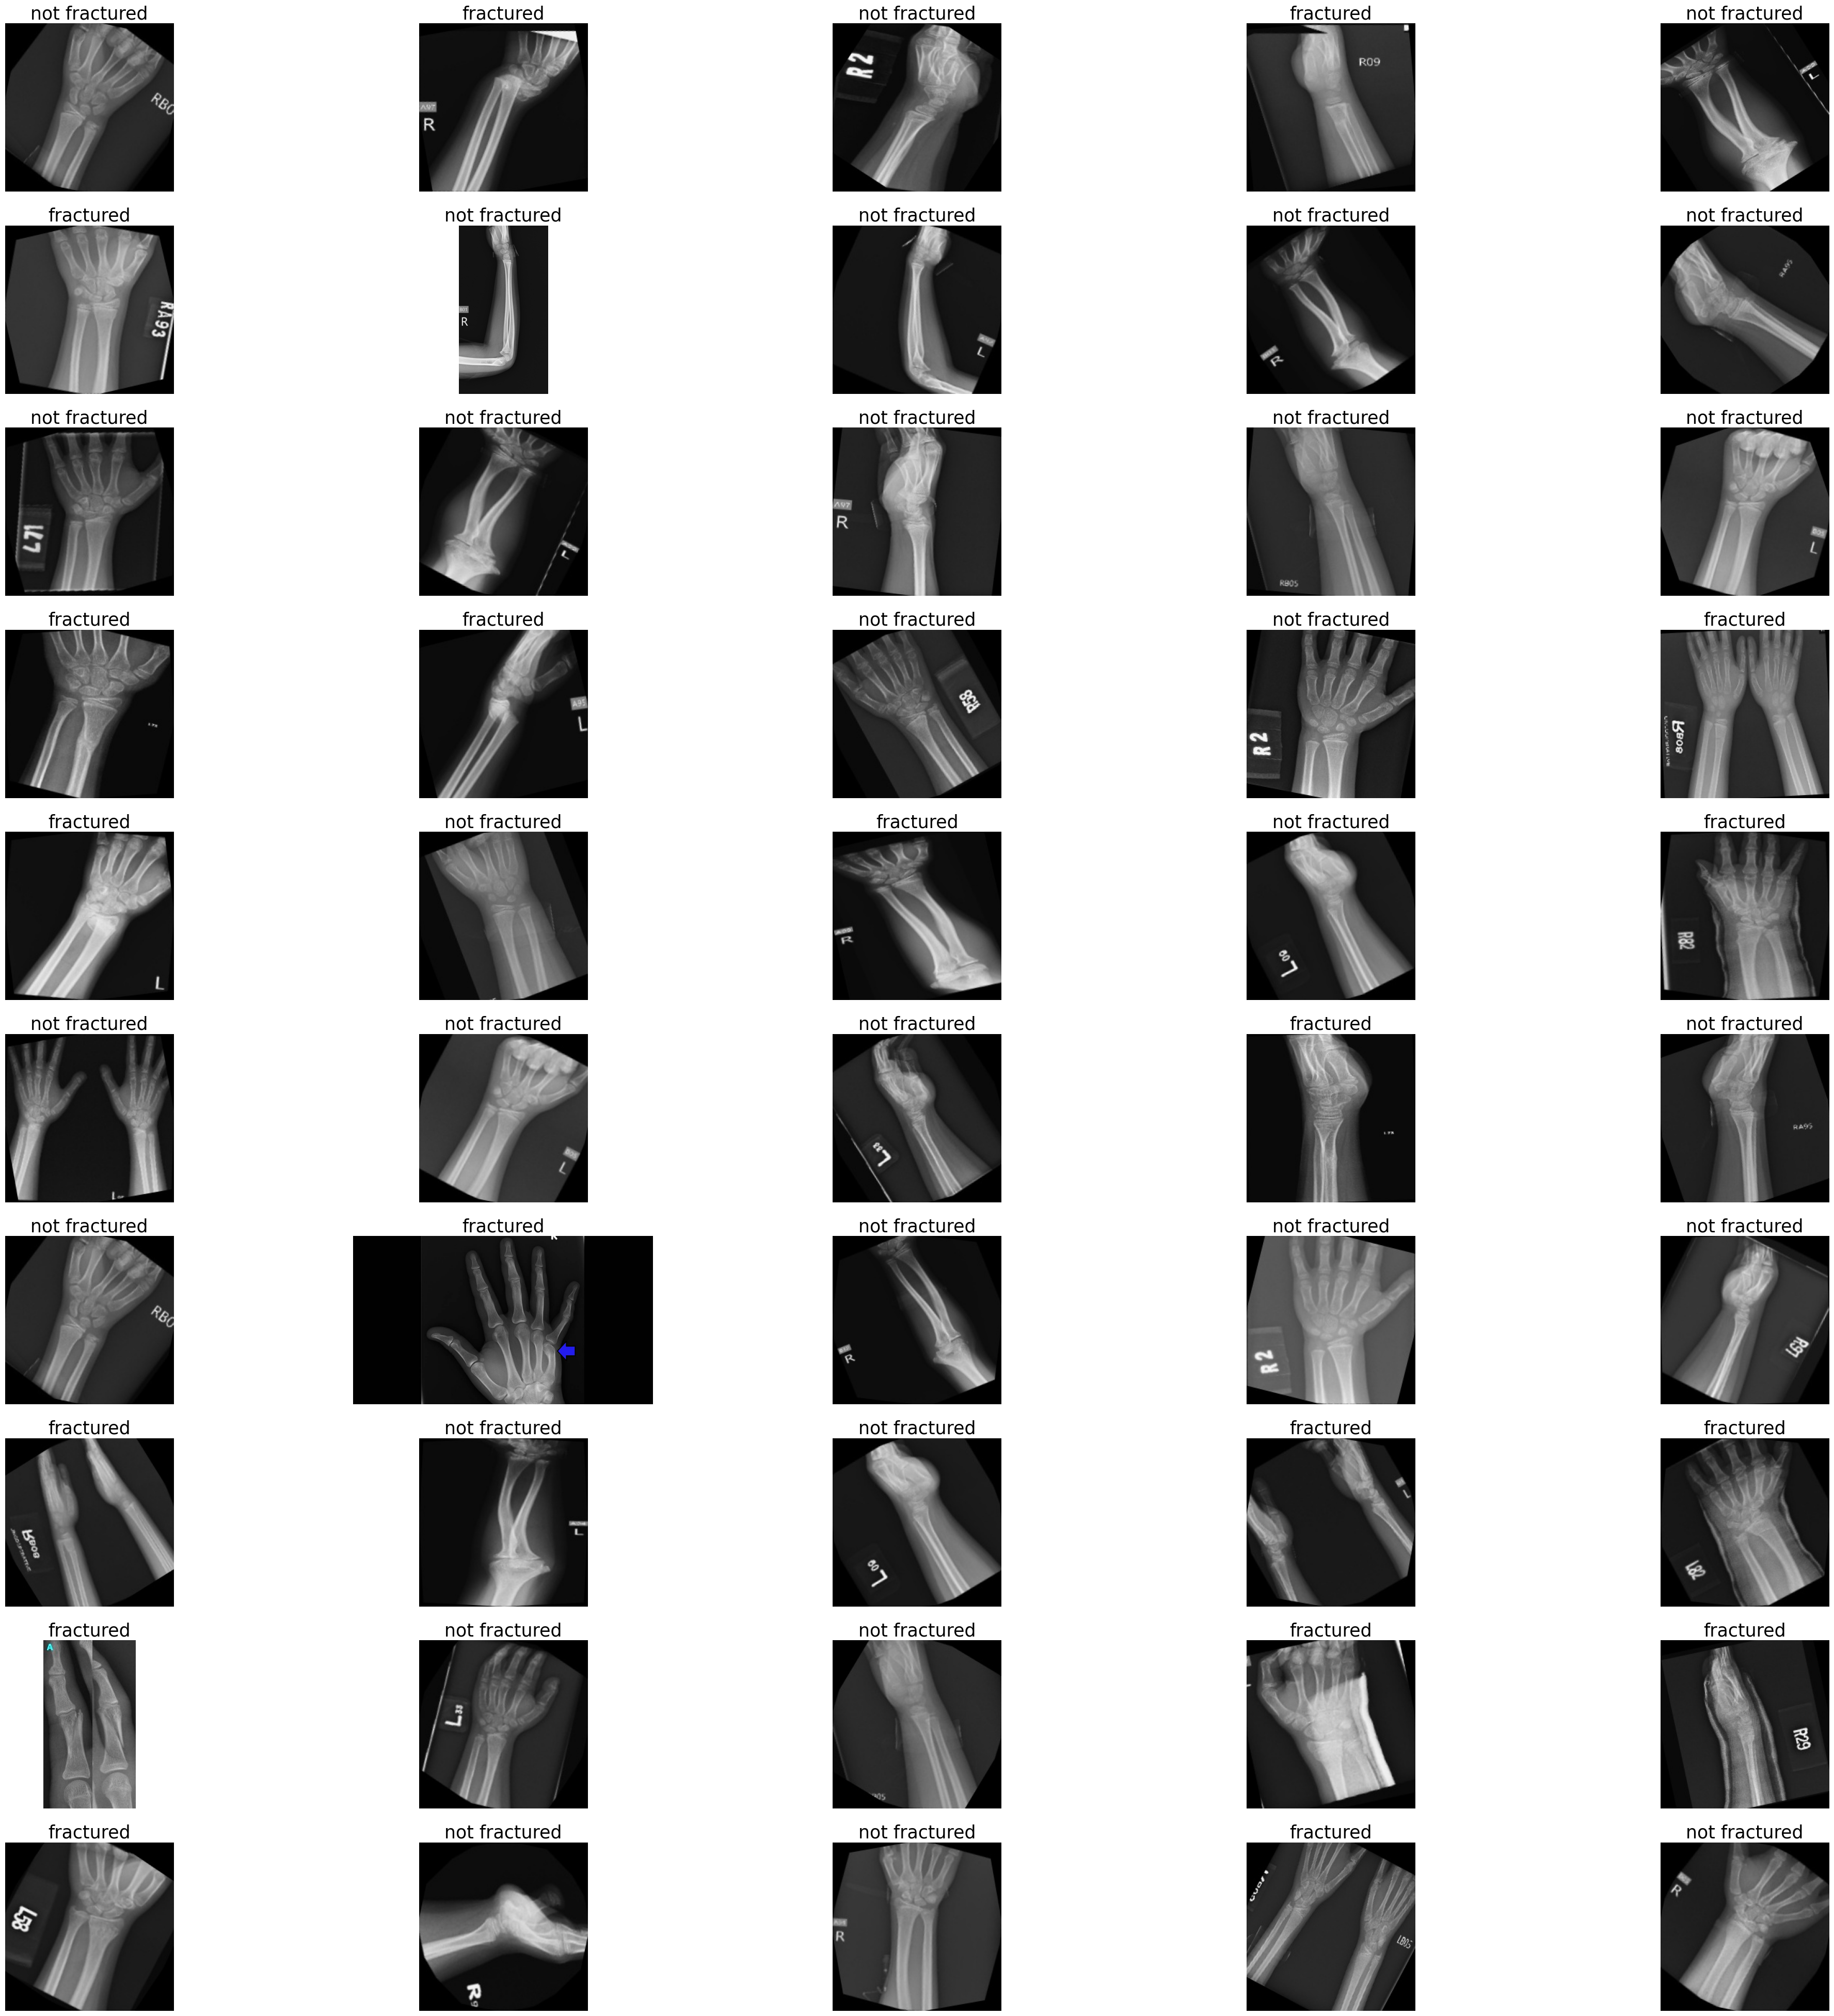

In [15]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

In [16]:
print(train['label'].value_counts())
print(test['label'].value_counts())
print(val['label'].value_counts())

label
not fractured    4613
fractured        4530
Name: count, dtype: int64
label
not fractured    250
fractured        199
Name: count, dtype: int64
label
not fractured    474
fractured        265
Name: count, dtype: int64


In [17]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 9143 validated image filenames belonging to 2 classes.
Found 449 validated image filenames belonging to 2 classes.
Found 739 validated image filenames belonging to 2 classes.


In [18]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,593 (84.99 MB)

 Trainable params: 22,278,145 (84.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
import os
from PIL import Image

def verify_images(directory):
    for foldername in os.listdir(directory):
        folder_path = os.path.join(directory, foldername)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, filename)
                try:
                    img = Image.open(image_path)
                    img.verify()  # Verify the image without loading it fully
                except (IOError, SyntaxError) as e:
                    print(f'Corrupted image: {image_path}')
                    os.remove(image_path)  # Remove corrupted image

verify_images('/content/drive/My Drive/Bone_Fracture_Binary_Classification/train')
verify_images('/content/drive/My Drive/Bone_Fracture_Binary_Classification/val')


In [20]:
 from	PIL	import	ImageFile
 ImageFile.LOAD_TRUNCATED_IMAGES	=	True

In [21]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callbacks
checkpoint_cb = ModelCheckpoint("my_keras_model.h5.keras", save_best_only=True)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.AUC()
    ]
)

# Train the model using `fit`
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint_cb]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


286/286 ━━━━━━━━━━━━━━━━━━━━ 91s 262ms/step - accuracy: 0.7083 - auc: 0.7465 - loss: 3.6022 - specificity_at_sensitivity: 0.8148 - val_accuracy: 0.6847 - val_auc: 0.6878 - val_loss: 1.0331 - val_specificity_at_sensitivity: 0.6755
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 107s 184ms/step - accuracy: 0.8771 - auc: 0.9369 - loss: 0.4407 - specificity_at_sensitivity: 0.9722 - val_accuracy: 0.8742 - val_auc: 0.9252 - val_loss: 0.4392 - val_specificity_at_sensitivity: 0.9660
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 52s 177ms/step - accuracy: 0.9197 - auc: 0.9709 - loss: 0.2655 - specificity_at_sensitivity: 0.9875 - val_accuracy: 0.8755 - val_auc: 0.9457 - val_loss: 0.6357 - val_specificity_at_sensitivity: 0.9736
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 90s 206ms/step - accuracy: 0.9494 - auc: 0.9862 - loss: 0.1621 - specificity_at_sensitivity: 0.9918 - val_accuracy: 0.9581 - val_auc: 0.9827 - val_loss: 0.1843 - val_specificity_at_sensitivity: 0.9887
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 52s 17

In [22]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy       auc      loss  specificity_at_sensitivity  val_accuracy  \
0  0.771300  0.822647  1.767015                    0.888300      0.684709   
1  0.892158  0.949538  0.386959                    0.979470      0.874154   
2  0.925954  0.974304  0.243330                    0.989625      0.875507   
3  0.950782  0.987695  0.150749                    0.993157      0.958051   
4  0.957344  0.990116  0.131066                    0.995806      0.909337   
5  0.962266  0.992240  0.116555                    0.996689      0.882273   
6  0.972110  0.993521  0.089433                    0.995806      0.976996   
7  0.977797  0.996410  0.063704                    0.997130      0.966170   
8  0.978891  0.997277  0.061755                    0.998455      0.978349   
9  0.981953  0.996990  0.053319                    0.998234      0.979702   

    val_auc  val_loss  val_specificity_at_sensitivity  
0  0.687776  1.033146                        0.675472  
1  0.925233  0.439223                        0.966038  
2  0.945749  0.635718                        0.973585  
3  0.982696  0.184330                        0.988679  
4  0.959892  0.681848                        0.996226  
5  0.965071  0.507473                        0.996226  
6  0.986060  0.138469                        0.977359  
7  0.993305  0.104657                        1.000000  
8  0.992437  0.071171                        0.988679  
9  0.993201  0.074334                        0.992453

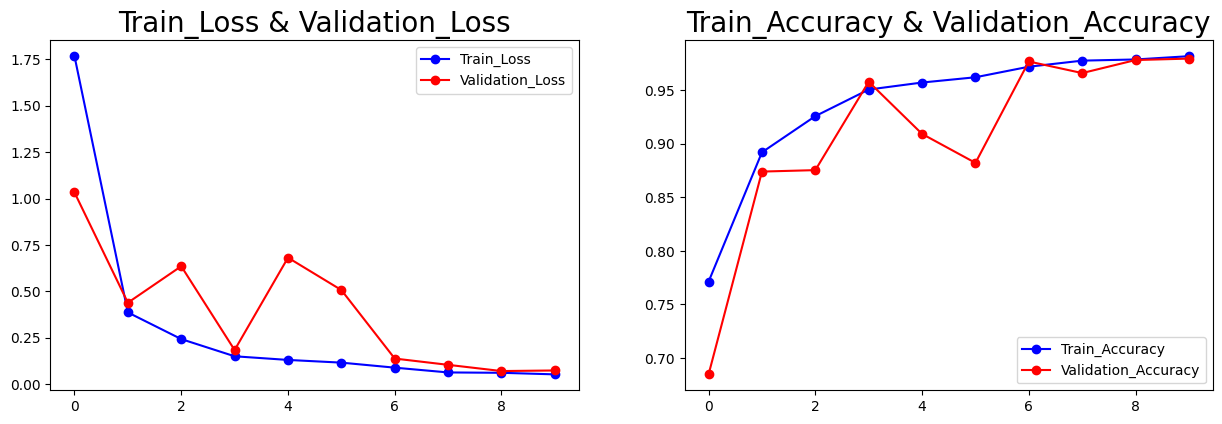

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

# Plot Loss
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()

# Plot Accuracy
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()



plt.show()


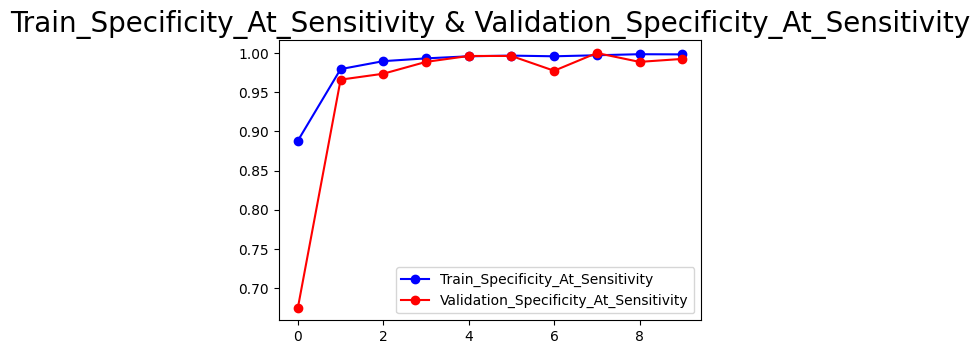

In [25]:
# Plot Specificity at Sensitivity
plt.figure(figsize=(12, 8))
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_Specificity_At_Sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_Specificity_At_Sensitivity')
plt.title('Train_Specificity_At_Sensitivity & Validation_Specificity_At_Sensitivity',fontsize=20)
plt.legend()


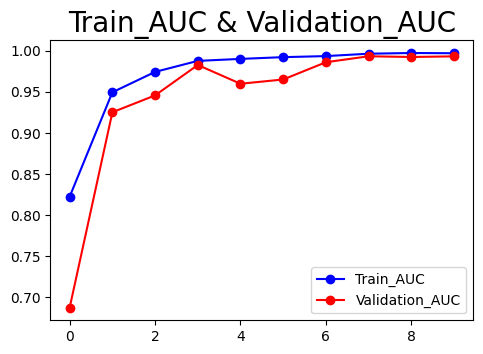

In [26]:
# Plot AUC
plt.figure(figsize=(12, 8))
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_AUC')
plt.plot(hist_['val_auc'],'r-o',label='Validation_AUC')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()

In [27]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0050 - specificity_at_sensitivity: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 106s 8s/step - accuracy: 0.9855 - auc: 0.5624 - loss: 0.0268 - specificity_at_sensitivity: 0.5625
Test Loss = 0.030277470126748085
Test Accuracy = 0.9821826219558716
Test Sensitivity = 1.0
Test AUC = 0.9998190999031067


In [28]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step


Actual  Prediction
0         1           1
1         1           1
2         1           1
3         1           1
4         1           1
..      ...         ...
444       0           0
445       0           0
446       0           0
447       0           0
448       0           0

[449 rows x 2 columns]

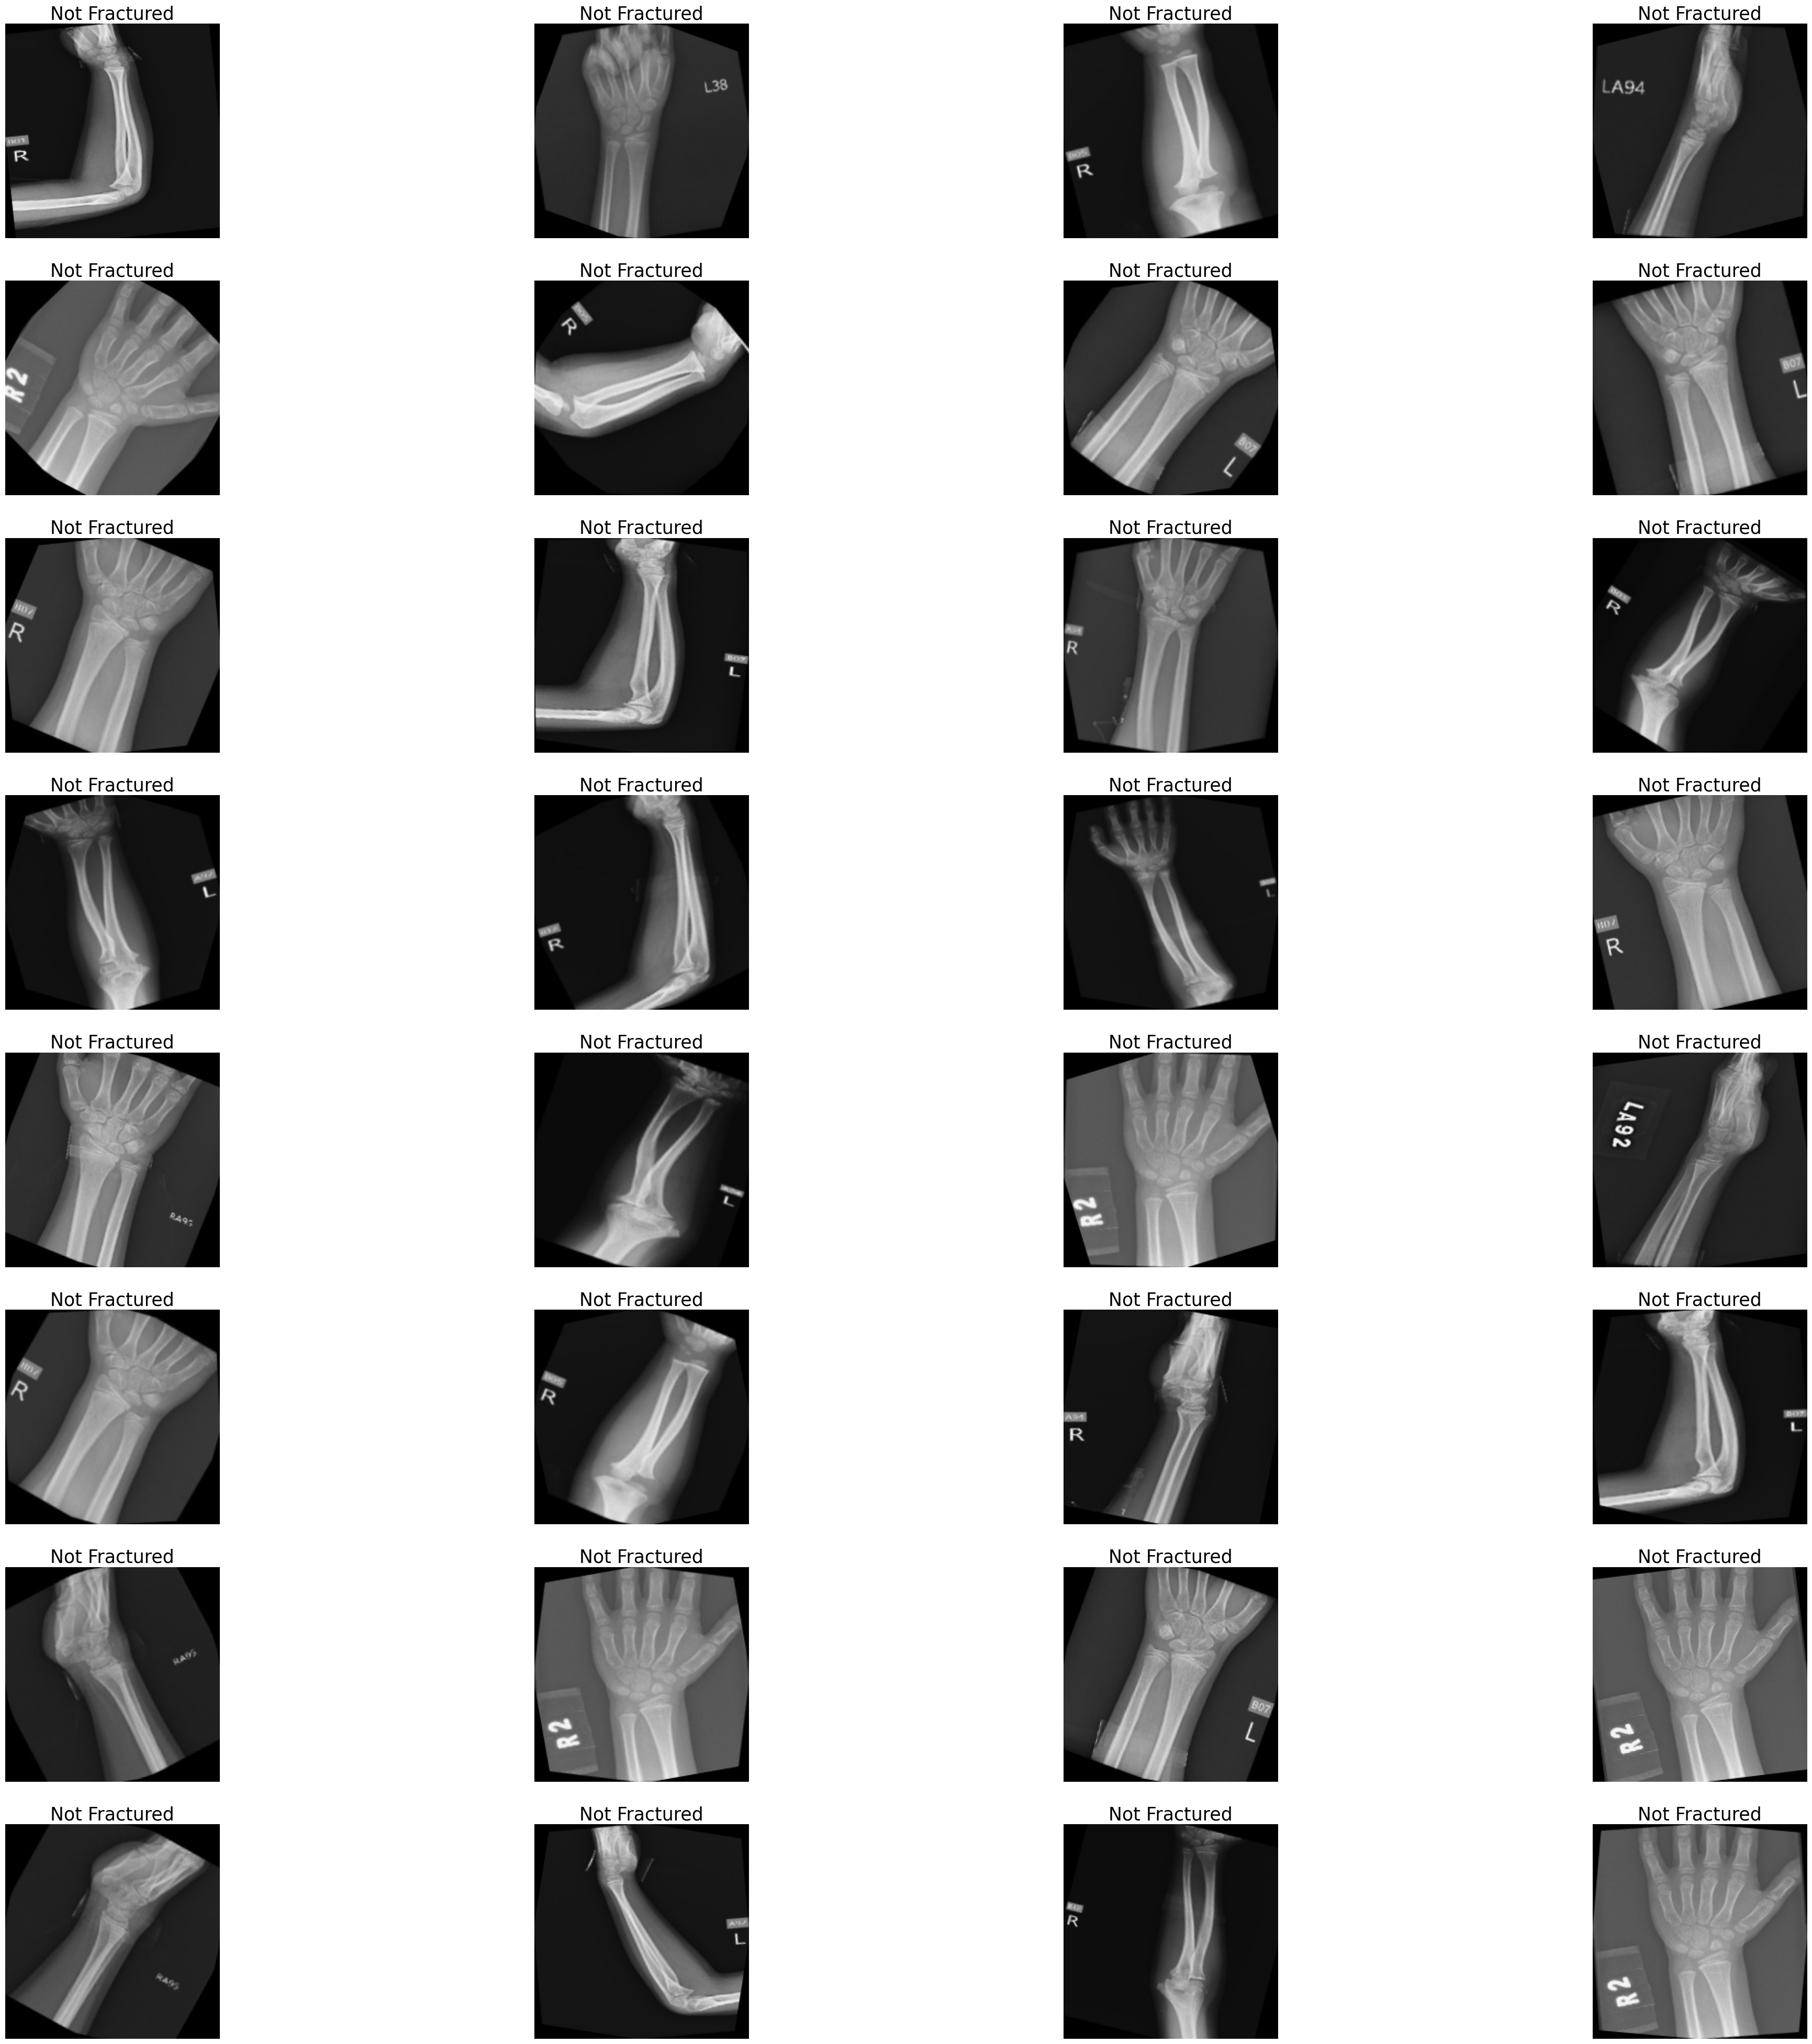

In [29]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

array([[198,   1],
       [  7, 243]])

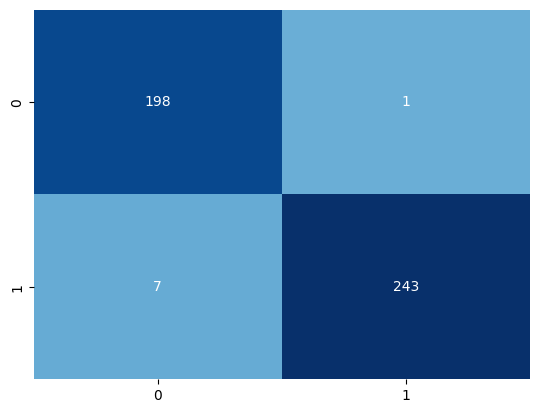

In [30]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [31]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.97      0.99      0.98       199
           1       1.00      0.97      0.98       250

    accuracy                           0.98       449
   macro avg       0.98      0.98      0.98       449
weighted avg       0.98      0.98      0.98       449

